# Vehicle Detection and Tracking Project

### Import needed data

In [1]:
import os
import cv2
import math
import time
import pickle
import numpy as np
from random import randint
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Define data set image paths for both positive and negative domains

In [2]:
Veh_Imgs_Path = "./../udacity_dataset/vehicles/vehicles/"
NonVeh_Imgs_Path = "./../udacity_dataset/non_vehicles/non_vehicles/"

Veh_Imgs = os.listdir(Veh_Imgs_Path)
NonVeh_Imgs = os.listdir(NonVeh_Imgs_Path)

### Collect Data set images

In [3]:
def CollectImages(folderpath, ImagePaths, isLabeled = True):
    images = []
    for ImagePath in ImagePaths:
        if (len(ImagePath.split('.')) == 2):
            im = cv2.imread(folderpath + ImagePath)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            #print('Image ' , ImagePath , ' is: ', type(im), ' with dimensions: ', im.shape)
            if isLabeled == True:
                images.append((im, ImagePath.split('.')[0]))
            else:
                images.append(im)
        else:
            print('Image', ImagePath, 'is correupted --> Discarded.')

    return images

In [4]:
CarImageSet = []
NonCarImageSet = []

for folder in Veh_Imgs:
    folderpath = Veh_Imgs_Path + folder
    Carsimagespath = os.listdir(folderpath)
    CarImageSet.append(CollectImages(folderpath + '/', Carsimagespath, True))

for folder in NonVeh_Imgs:
    folderpath = NonVeh_Imgs_Path + folder
    NonCarsimagespath = os.listdir(folderpath)
    NonCarImageSet.append(CollectImages(folderpath + '/', NonCarsimagespath, True))

CarImageSet = np.concatenate(CarImageSet)
NonCarImageSet = np.concatenate(NonCarImageSet)

print('Car Image Set has ', str(len(CarImageSet)))
print('Non Car Image Set has ', str(len(NonCarImageSet)))

Car Image Set has  8792
Non Car Image Set has  8968


### Define to access both image pixel values and labels

In [5]:
imgPxlVal = 0
img_Label = 1

## Visualize DataSet

In [6]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) <= (nrows * ncols)
    if labels != "":
        assert len(images) == len(labels)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        if labels != "":
            plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

In [ ]:
vis_imgs = []
vis_labels = []

#show 12 random images from Car dataset
for i in range(12):
    index = randint(0, len(CarImageSet))
    vis_imgs.append(CarImageSet[index][imgPxlVal])
    vis_labels.append('Car')

#show 12 random images from Not Car dataset
for i in range(12):
    index = randint(0, len(NonCarImageSet))
    vis_imgs.append(NonCarImageSet[index][imgPxlVal])
    vis_labels.append('Not Car')

pltImages(vis_imgs, vis_labels, 2, 12, 16, 4)

### Visualize color space features using histograms

In [ ]:
def pltHistograms(hists, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, xlim = [0,256]):
    assert len(hists) == len(labels)
    assert len(hists) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(hists)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        plt.plot(hists[index])
        plt.xlim(xlim)
    
    plt.tight_layout()
    plt.show()

In [ ]:
Channel_0 = 0
Channel_1 = 1
Channel_2 = 2

histSize = [48]
histrange = [0,255]

ColorSpace = ['RGB','HSV','HLS', 'LAB', 'YUV', 'LUV', 'YCrCb']

In [ ]:
def ExploreColorSpaceHistogram(img):
    hist = []
    hist_label = []

    hist_0 = cv2.calcHist(img,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(img,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(img,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("RGB_Channel 0")
    hist.append(hist_1)
    hist_label.append("RGB_Channel 1")
    hist.append(hist_2)
    hist_label.append("RGB_Channel 2")

    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hist_0 = cv2.calcHist(HSV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HSV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HSV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HSV_Channel 0")
    hist.append(hist_1)
    hist_label.append("HSV_Channel 1")
    hist.append(hist_2)
    hist_label.append("HSV_Channel 2")

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    hist_0 = cv2.calcHist(HLS,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HLS,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HLS,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HLS_Channel 0")
    hist.append(hist_1)
    hist_label.append("HLS_Channel 1")
    hist.append(hist_2)
    hist_label.append("HLS_Channel 2")

    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    hist_0 = cv2.calcHist(LAB,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LAB,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LAB,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LAB_Channel 0")
    hist.append(hist_1)
    hist_label.append("LAB_Channel 1")
    hist.append(hist_2)
    hist_label.append("LAB_Channel 2")

    YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    hist_0 = cv2.calcHist(YUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("YUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("YUV_Channel 2")

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    hist_0 = cv2.calcHist(LUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("LUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("LUV_Channel 2")
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    hist_0 = cv2.calcHist(YCrCb,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YCrCb,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YCrCb,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YCrCb_Channel 0")
    hist.append(hist_1)
    hist_label.append("YCrCb_Channel 1")
    hist.append(hist_2)
    hist_label.append("YCrCb_Channel 2")

    pltHistograms(hist, hist_label, 7, 3, xlim = [0, histSize[0]-1])

In [ ]:
#CarImageIndex = 0
CarImageIndex = randint(0, len(CarImageSet))
CarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
CarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(CarImage, CarImageLabel, 1, 1)
ExploreColorSpaceHistogram(CarImage[0])

#NonCarImageIndex = 0
NonCarImageIndex = randint(0, len(NonCarImageSet))
NonCarImage = [NonCarImageSet[NonCarImageIndex][imgPxlVal]]
NonCarImageLabel = [NonCarImageSet[NonCarImageIndex][img_Label]]

pltImages(NonCarImage, NonCarImageLabel, 1, 1)
ExploreColorSpaceHistogram(NonCarImage[0])

Spatial Binning

In [7]:
#Code obtained from Udacity lesson 16
def bin_spatial_Demo_colorspace(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [ ]:
size=(8, 8)

In [ ]:
vis_imgs = []
vis_labels = []

index = randint(0, len(CarImageSet))

vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], size=size))
vis_labels.append('RGB')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='HSV', size=size))
vis_labels.append('HSV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='LUV', size=size))
vis_labels.append('LUV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='HLS', size=size))
vis_labels.append('HLS')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='YUV', size=size))
vis_labels.append('YUV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='YCrCb', size=size))
vis_labels.append('YCrCb')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='LAB', size=size))
vis_labels.append('LAB')

pltImages([CarImageSet[index][imgPxlVal]], ["Original Image"], 1, 1, 20, 2)
pltHistograms(vis_imgs, vis_labels, 7, 1, xlim = [0, 200])

vis_imgs = []
vis_labels = []

index = randint(0, len(NonCarImageSet))

vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], size=size))
vis_labels.append('RGB')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='HSV', size=size))
vis_labels.append('HSV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='LUV', size=size))
vis_labels.append('LUV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='HLS', size=size))
vis_labels.append('HLS')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='YUV', size=size))
vis_labels.append('YUV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='YCrCb', size=size))
vis_labels.append('YCrCb')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='LAB', size=size))
vis_labels.append('LAB')

pltImages([NonCarImageSet[index][imgPxlVal]], ["Original Image"], 1, 1, 20, 2)
pltHistograms(vis_imgs, vis_labels, 7, 1, xlim = [0, 200])

#### I started with resize to 32*32 but the output proved to be very large, 3072, which I consider very large for a soft qualifier like this and better to be downsampled to 8*8

#### All color spaces provide different signatures between the two classes, take RGB for simplicity

### Visualize HOG features

In [8]:
def get_hog_features_demo(img, orient, pix_per_cell, cell_per_block, blockNorm, trns_sqrt, visualize=False, feature_vec=True):
    if visualize == True:
        features, hog_im = hog(img,
                               orientations=orient,
                               pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block, cell_per_block),
                               block_norm = blockNorm, #Block Normalize didn't show any change effect on image
                               transform_sqrt=trns_sqrt, 
                               visualise=visualize,
                               feature_vector=feature_vec)
        return features, hog_im
    else:      
        features = hog(img,
                       orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm = blockNorm, #Block Normalize didn't show any change effect on image
                       transform_sqrt=trns_sqrt, 
                       visualise=visualize,
                       feature_vector=feature_vec)
        return features

In [ ]:
orient = 8
pix_per_cell = 16
cells_per_block = 2
TransformSqrt = True

blockNorm = ['L1', 'L1-sqrt', 'L2', 'L2-Hys']

hc = 'ALL'

In [ ]:
def VisauliseHOG(img):
    vis = True
    __, hog_im = get_hog_features_demo(
        img,
        orient,
        pix_per_cell,
        cells_per_block,
        'L2-Hys',
        visualize=vis,
        trns_sqrt=TransformSqrt,
        feature_vec=False)
    return hog_im

In [ ]:
def ExploreHOGSpace(img):
    HOG_IMs = []
    hog_label = []
    
    hog_0 = VisauliseHOG(img[:,:,Channel_0])
    hog_1 = VisauliseHOG(img[:,:,Channel_1])
    hog_2 = VisauliseHOG(img[:,:,Channel_2])
    pltImages([hog_0], ["RGB_Channel 0"], 1, 1)
    pltImages([hog_1], ["RGB_Channel 1"], 1, 1)
    pltImages([hog_2], ["RGB_Channel 2"], 1, 1)

    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hog_0 = VisauliseHOG(HSV[:,:,Channel_0])
    hog_1 = VisauliseHOG(HSV[:,:,Channel_1])
    hog_2 = VisauliseHOG(HSV[:,:,Channel_2])
    pltImages([hog_0], ["HSV_Channel 0"], 1, 1)
    pltImages([hog_1], ["HSV_Channel 1"], 1, 1)
    pltImages([hog_2], ["HSV_Channel 2"], 1, 1)

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    hog_0 = VisauliseHOG(HLS[:,:,Channel_0])
    hog_1 = VisauliseHOG(HLS[:,:,Channel_1])
    hog_2 = VisauliseHOG(HLS[:,:,Channel_2])
    pltImages([hog_0], ["HLS_Channel 0"], 1, 1)
    pltImages([hog_1], ["HLS_Channel 1"], 1, 1)
    pltImages([hog_2], ["HLS_Channel 2"], 1, 1)

    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    hog_0 = VisauliseHOG(LAB[:,:,Channel_0])
    hog_1 = VisauliseHOG(LAB[:,:,Channel_1])
    hog_2 = VisauliseHOG(LAB[:,:,Channel_2])
    pltImages([hog_0], ["LAB_Channel 0"], 1, 1)
    pltImages([hog_1], ["LAB_Channel 1"], 1, 1)
    pltImages([hog_2], ["LAB_Channel 2"], 1, 1)

    YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    hog_0 = VisauliseHOG(YUV[:,:,Channel_0])
    hog_1 = VisauliseHOG(YUV[:,:,Channel_1])
    hog_2 = VisauliseHOG(YUV[:,:,Channel_2])
    pltImages([hog_0], ["YUV_Channel 0"], 1, 1)
    pltImages([hog_1], ["YUV_Channel 1"], 1, 1)
    pltImages([hog_2], ["YUV_Channel 2"], 1, 1)

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    hog_0 = VisauliseHOG(LUV[:,:,Channel_0])
    hog_1 = VisauliseHOG(LUV[:,:,Channel_1])
    hog_2 = VisauliseHOG(LUV[:,:,Channel_2])
    pltImages([hog_0], ["LUV_Channel 0"], 1, 1)
    pltImages([hog_1], ["LUV_Channel 1"], 1, 1)
    pltImages([hog_2], ["LUV_Channel 2"], 1, 1)
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    hog_0 = VisauliseHOG(YCrCb[:,:,Channel_0])
    hog_1 = VisauliseHOG(YCrCb[:,:,Channel_1])
    hog_2 = VisauliseHOG(YCrCb[:,:,Channel_2])
    pltImages([hog_0], ["YCrCb_Channel 0"], 1, 1)
    pltImages([hog_1], ["YCrCb_Channel 1"], 1, 1)
    pltImages([hog_2], ["YCrCb_Channel 2"], 1, 1)

In [ ]:
CarImageIndex = 0
#CarImageIndex = randint(0, len(CarImageSet))
HOGCarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
HOGCarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(HOGCarImage, HOGCarImageLabel, 1, 1)
ExploreHOGSpace(HOGCarImage[0])

NonCarImageIndex = 0
#NonCarImageIndex = randint(0, len(NonCarImageSet))
HOGNonCarImage = [NonCarImageSet[NonCarImageIndex][imgPxlVal]]
HOGCarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(HOGNonCarImage, HOGCarImageLabel, 1, 1)
ExploreHOGSpace(HOGNonCarImage[0])

# Enough Visualization :D, Let's Extract Some Features

In [ ]:
AllowedColorSpace = ['RGB','HSV','HLS', 'LAB', 'YUV', 'LUV', 'YCrCb']
AllowedblockNorm = ['L1', 'L1-sqrt', 'L2', 'L2-Hys']

#Calibration Parameters
CHist_EN=False
SB_EN=False
HOG_EN=True
Nrmlz=False

#Color Histogram
histSize = [48]
histrange = [0,255]
Hist_colorspace = "RGB"
CS_Ch_Idx = "All"

#Spatial Binning
size=(8, 8)
SB_colorspace = "RGB"

#HOG Params
HOG_colorspace = "RGB"
orient = 8
pix_per_cell = 16
cells_per_block = 2
blk_Norm = "L2-Hys"
TransformSqrt = True
feat_vec = True
HOG_Ch_Idx = "All"

In [9]:
def normalize(data):
    return preprocessing.normalize(data)

In [10]:
def extractFeatures(img,debug=False,ReturnSizes=False):
    
    hist_feat = []
    SB_feat = []
    hog_feat = []
    
    hist_feat_shape = 0
    SB_feat_shape   = 0
    hog_feat_shape  = 0
    
    histrange = [0,255]
    
    if CHist_EN == True:
        #Extract Color Hitogram Features
        if Hist_colorspace == "HSV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif Hist_colorspace == "HLS":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif Hist_colorspace == "LAB":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif Hist_colorspace == "YUV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif Hist_colorspace == "LUV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif Hist_colorspace == "YCrCb":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume No action needed
            hist_image = np.copy(img)
        
        if CS_Ch_Idx != "All":
            hist_feat = cv2.calcHist(hist_image,[CS_Ch_Idx],None,histSize,histrange)
        else:
            hist_feat = []
            for Ch_Idx in range(hist_image.shape[2]):
                hist_feat.append(cv2.calcHist(hist_image,[Ch_Idx],None,histSize,histrange))
        
        hist_feat = np.ravel(hist_feat).reshape(1, -1)

        if debug == True:
            print("Histogram")
            print("Before Normalize")
            print(hist_feat.shape)
            print(hist_feat)
        
        if Nrmlz == True:
            hist_feat = normalize(hist_feat)
            if debug == True:
                print("After Normalize")
                print(hist_feat.shape)
                print(hist_feat)
                
        hist_feat = hist_feat[0]
        hist_feat_shape = hist_feat.shape
        
    if SB_EN == True:
        #Extract Spatial Binning Features
        if Hist_colorspace == "HSV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif Hist_colorspace == "HLS":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif Hist_colorspace == "LAB":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif Hist_colorspace == "YUV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif Hist_colorspace == "LUV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif Hist_colorspace == "YCrCb":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume No action needed
            SB_image = np.copy(img)
        
        SB_feat = cv2.resize(SB_image, size).ravel().reshape(1, -1).astype(np.float64)

        if debug == True:
            print("Spatial Binning")
            print("Before Normalize")
            print(SB_feat.shape)
            print(SB_feat)
        
        if Nrmlz == True:
            SB_feat = normalize(SB_feat)
            if debug == True:
                print("After Normalize")
                print(SB_feat.shape)
                print(SB_feat)
                
        SB_feat = SB_feat[0]
        SB_feat_shape = SB_feat.shape
    
    if HOG_EN == True:
        #Extract HOG Features
        if HOG_colorspace == "HSV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif HOG_colorspace == "HLS":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif HOG_colorspace == "LAB":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif HOG_colorspace == "YUV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif HOG_colorspace == "LUV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif HOG_colorspace == "YCrCb":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume No action needed
            hog_image = np.copy(img)
        
        if HOG_Ch_Idx != "All":
            hog_feat = get_hog_features_demo(
                img[:,:,HOG_Ch_Idx],
                orient,
                pix_per_cell,
                cells_per_block,
                blk_Norm,
                visualize=False,
                trns_sqrt=TransformSqrt,
                feature_vec=True)
        else:
            for Ch_Idx in range(hog_image.shape[2]):
                hog_feat.append(get_hog_features_demo(
                    img[:,:,Ch_Idx],
                    orient,
                    pix_per_cell,
                    cells_per_block,
                    blk_Norm,
                    visualize=False,
                    trns_sqrt=TransformSqrt,
                    feature_vec=True))
        
        hog_feat = np.ravel(hog_feat).reshape(1, -1)
        
        if debug == True:
            print("HOG")
            print("Before Normalize")
            print(hog_feat.shape)
            print(hog_feat)
        
        if Nrmlz == True:
            hog_feat = normalize(hog_feat)
            if debug == True:
                print("After Normalize")
                print(hog_feat.shape)
                print(hog_feat)
                
        hog_feat = hog_feat[0]
        hog_feat_shape = hog_feat.shape
    
    if debug == True:
        print("Before Concatenation")
        print(hist_feat)
        print(SB_feat)
        print(hog_feat)
    
    features = np.hstack((hist_feat, SB_feat, hog_feat))
    
    if debug == True:
        print("Output")
        print(len(features))
        print(features)
    
    #features = np.ravel(features)
    
    #if debug == True:
        #print(features.shape)
        #print(features)

    if ReturnSizes == False:
        return features
    else:
        return (hist_feat_shape, 
                SB_feat_shape, 
                hog_feat_shape, 
                features)

##### Test Feature Extraction Function

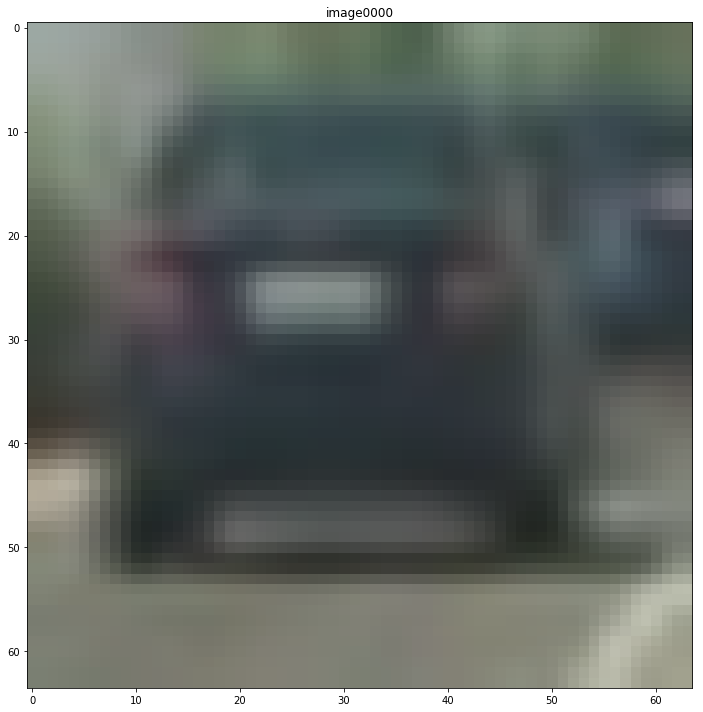

(192,)
(768,)
(864,)


In [54]:
CarImageIndex = 0
#CarImageIndex = randint(0, len(CarImageSet))
HOGCarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
HOGCarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(HOGCarImage, HOGCarImageLabel, 1, 1)
Test = extractFeatures(HOGCarImage[0],
                       debug=False,
                       ReturnSizes=True)
print(Test[0])
print(Test[1])
print(Test[2])

In [172]:
def TrainLinearSVCModel(feat, label):
    svc = LinearSVC()
    svc.fit(feat, label)

    return svc

def TrainModel_WithParameterSearch(feat, label):
    parameters = {'C':[0.1, 100]}

    svc = LinearSVC()
    clf = GridSearchCV(svc, parameters)
    clf.fit(feat, label)

    return clf

def TrainSVCModel(feat, label):
    svc = SVC(kernel='linear')
    svc.fit(feat, label)

    return svc

#below code is obtained from http://scikit-learn.org/stable/modules/model_persistence.html
def SaveModelFunc(clf, Name='TrainedModel.pkl'):
    s = pickle.dumps(clf)
    joblib.dump(clf, Name)

def LoadModelFunc(Name='TrainedModel.pkl'):
    return joblib.load(Name)

def SaveScalerFunc(Scal, Name='TrainedScaler.pkl'):
    s = pickle.dumps(Scal)
    joblib.dump(clf, Name)

def LoadScalerFunc(Name='TrainedScaler.pkl'):
    return joblib.load(Name) 

## Expolre Different parameters as discussed in the sheet

In [12]:
PTNormalize      = 0
PTCHist_EN       = 1
PTCHist_BCnt     = 2
PTCHist_CSpace   = 3
PTCHist_Ch_Idx   = 4
PTSB_EN          = 5
PTSB_Size        = 6
PTSB_CSpace      = 7
PTHOG_EN         = 8
PTHOG_OrientCnt  = 9
PTHOG_Px_Per_Cl  = 10
PTHOG_Cl_Per_Blk = 11
PTHOG_Blk_Nrmlz  = 12
PTHOG_Trnsf_Sqrt = 13
PTHOG_CSpace     = 14
PTHOG_Ch_Indx    = 15

In [13]:
def ParameterTuning(SaveModel = False):
    global CHist_EN
    global SB_EN
    global HOG_EN
    global Nrmlz
    global histSize
    global Hist_colorspace
    global CS_Ch_Idx
    global size
    global SB_colorspace
    global HOG_colorspace
    global orient
    global pix_per_cell
    global cells_per_block
    global blk_Norm
    global TransformSqrt
    global HOG_Ch_Idx
     
    SearchTrials=[
        [True ,True ,[64],"LUV","All",True ,(16,16),"LUV",True ,8,16,2,"L2",True ,"LUV","All"]
    ]

    for cnt in range(0,5):
        for idx in range(0, len(SearchTrials)):
            CHist_EN  = SearchTrials[idx][PTCHist_EN]
            SB_EN     = SearchTrials[idx][PTSB_EN]
            HOG_EN    = SearchTrials[idx][PTHOG_EN]
            Nrmlz     = SearchTrials[idx][PTNormalize]
            histSize  = SearchTrials[idx][PTCHist_BCnt]
            Hist_colorspace = SearchTrials[idx][PTCHist_CSpace]
            CS_Ch_Idx = SearchTrials[idx][PTCHist_Ch_Idx]
            size      = SearchTrials[idx][PTSB_Size]
            SB_colorspace   = SearchTrials[idx][PTSB_CSpace]
            HOG_colorspace  = SearchTrials[idx][PTHOG_CSpace]
            orient    = SearchTrials[idx][PTHOG_OrientCnt]
            pix_per_cell    = SearchTrials[idx][PTHOG_Px_Per_Cl]
            cells_per_block = SearchTrials[idx][PTHOG_Cl_Per_Blk]
            blk_Norm  = SearchTrials[idx][PTHOG_Blk_Nrmlz]
            TransformSqrt   = SearchTrials[idx][PTHOG_Trnsf_Sqrt]
            HOG_Ch_Idx= SearchTrials[idx][PTHOG_Ch_Indx]

            #Test = extractFeatures(HOGCarImage[0])

            #start_time = time.time()
            
            lCar_features = []
            lNonCar_features = []

            for image in CarImageSet:
                COut = extractFeatures(image[imgPxlVal], ReturnSizes=True)
                lCar_features.append(COut[3])

            for image in NonCarImageSet:
                NCOut = extractFeatures(image[imgPxlVal], ReturnSizes=True)
                lNonCar_features.append(NCOut[3])

            lFeatureSet = np.vstack((lCar_features, lNonCar_features)).astype(np.float64)
            lLbaelSet = np.hstack((np.ones(len(lCar_features)), np.zeros(len(lNonCar_features))))

            lrand_state = 20
            #lrand_state = np.random.randint(0, 100)
            lFeature_train, lFeature_test, lLabel_train, lLabel_test = train_test_split(lFeatureSet, lLbaelSet, test_size=0.2, random_state=lrand_state)
            
            lFeature_scaler = StandardScaler().fit(lFeature_train)
            lScaled_FeatureTrainSet = lFeature_scaler.transform(lFeature_train)
            lScaled_FeatureTestSet = lFeature_scaler.transform(lFeature_test)

            clf = TrainLinearSVCModel(lScaled_FeatureTrainSet, lLabel_train)
            #clf = TrainModel_WithParameterSearch(lFeature_train, lLabel_train)
            
            if SaveModel == True:
                Name = "TrainedModel" + str(cnt) + ".pkl"
                SaveModelFunc(clf, Name)

            start_time = time.time()
            
            acc = clf.score(lScaled_FeatureTestSet, lLabel_test)
            
            elapsed_time = time.time() - start_time

            print("Param Set(",idx,") result in acc of ",acc," CH Feat cnt=",COut[0]," SB Feat cnt=",COut[1]," HOG Feat cnt=",COut[2]," In time:",elapsed_time)
            #print("Param value", clf.best_params_)
    
ParameterTuning()

Param Set( 0 ) result in acc of  0.990990990991  CH Feat cnt= (192,)  SB Feat cnt= (768,)  HOG Feat cnt= (864,)  In time: 0.02205944061279297
Param Set( 0 ) result in acc of  0.990990990991  CH Feat cnt= (192,)  SB Feat cnt= (768,)  HOG Feat cnt= (864,)  In time: 0.013034582138061523
Param Set( 0 ) result in acc of  0.990990990991  CH Feat cnt= (192,)  SB Feat cnt= (768,)  HOG Feat cnt= (864,)  In time: 0.015016317367553711
Param Set( 0 ) result in acc of  0.990990990991  CH Feat cnt= (192,)  SB Feat cnt= (768,)  HOG Feat cnt= (864,)  In time: 0.013063669204711914
Param Set( 0 ) result in acc of  0.990990990991  CH Feat cnt= (192,)  SB Feat cnt= (768,)  HOG Feat cnt= (864,)  In time: 0.013009071350097656


In [14]:
#Feature Extraction Chsoen Parameters
ParamList = [True ,True ,[64],"LUV","All",True ,(16,16),"LUV",True ,8,16,2,"L2",True ,"LUV","All"]

CHist_EN  = ParamList[PTCHist_EN]
SB_EN     = ParamList[PTSB_EN]
HOG_EN    = ParamList[PTHOG_EN]
Nrmlz     = ParamList[PTNormalize]
histSize  = ParamList[PTCHist_BCnt]
Hist_colorspace = ParamList[PTCHist_CSpace]
CS_Ch_Idx = ParamList[PTCHist_Ch_Idx]
size      = ParamList[PTSB_Size]
SB_colorspace   = ParamList[PTSB_CSpace]
HOG_colorspace  = ParamList[PTHOG_CSpace]
orient    = ParamList[PTHOG_OrientCnt]
pix_per_cell    = ParamList[PTHOG_Px_Per_Cl]
cells_per_block = ParamList[PTHOG_Cl_Per_Blk]
blk_Norm  = ParamList[PTHOG_Blk_Nrmlz]
TransformSqrt   = ParamList[PTHOG_Trnsf_Sqrt]
HOG_Ch_Idx= ParamList[PTHOG_Ch_Indx]

In [15]:
Car_features = []
NonCar_features = []

for image in CarImageSet:
    Car_features.append(extractFeatures(image[imgPxlVal]))
print("Car Feature Collected")

for image in NonCarImageSet:
    NonCar_features.append(extractFeatures(image[imgPxlVal]))
print("Non Car Feature Collected")

Car Feature Collected
Non Car Feature Collected


In [16]:
FeatureSet = np.vstack((Car_features, NonCar_features)).astype(np.float64)
LbaelSet = np.hstack((np.ones(len(Car_features)), np.zeros(len(NonCar_features))))

In [17]:
rand_state = 20
#rand_state = np.random.randint(0, 100)
Feature_train, Feature_test, Label_train, Label_test = train_test_split(FeatureSet, LbaelSet, test_size=0.2, random_state=rand_state)

In [18]:
Feature_scaler = StandardScaler().fit(Feature_train)
Scaled_FeatureTrainSet = Feature_scaler.transform(Feature_train)
Scaled_FeatureTestSet = Feature_scaler.transform(Feature_test)

In [19]:
print(FeatureSet.mean())
print(FeatureSet.std())
print(Scaled_FeatureTrainSet.mean())
print(Scaled_FeatureTrainSet.std())
print(Scaled_FeatureTestSet.mean())
print(Scaled_FeatureTestSet.std())

0.0282440452818
0.0291034490752
1.3654058654e-15
1.0
-0.00265915335828
0.999593247712


### Train/Load Model

In [20]:
print("Training")
clf = TrainLinearSVCModel(Scaled_FeatureTrainSet, Label_train)
SaveModelFunc(clf, "ClassifierWithFeatureCount_1824.pkl")

Training


In [ ]:
print("Load Trained Model")

clf = LoadModelFunc(Name="TrainedModel9.pkl")

In [174]:
SaveModelFunc(clf, "Test.pkl")
SaveScalerFunc(Feature_scaler)

### Test Model

In [21]:
print('Test Accuracy of SVC = ', clf.score(Scaled_FeatureTestSet, Label_test))

for i in range(10):
    print('My SVC predicts: ', clf.predict(Scaled_FeatureTestSet[i].reshape(1, -1)), 'for label: ', Label_test[i])

Test Accuracy of SVC =  0.990990990991
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 1.] for label:  1.0
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 1.] for label:  1.0
My SVC predicts:  [ 1.] for label:  1.0
My SVC predicts:  [ 0.] for label:  0.0


## Ok We now have selected our tuned parameters for Liner SVM, Moving on to Sliding Windows Implementation

In [30]:
Inpath  = "./test_images"
TestimagesPaths = os.listdir(Inpath)

TestImages = CollectImages(Inpath + '/', TestimagesPaths, isLabeled = False)

In [22]:
def draw_boxes(img, bboxes, thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, 
                      bbox[0], 
                      bbox[1], 
                      color, 
                      thick)
    # Return the image copy with boxes drawn
    return imcopy

In [23]:
#nearly the same function in lessons
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), debug=False):
    if x_start_stop == [None, None]:
        x_start_stop = [0, img.shape[1]]
    if y_start_stop == [None, None]:
        y_start_stop = [0, img.shape[0]]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    if debug == True:
        return (window_list, nx_windows, ny_windows)
    else:
        return window_list

In [ ]:
y = TestImages[0].shape[0]
x = TestImages[0].shape[1]

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.6), np.int(y * 0.7)]

windows= slide_window(TestImages[0], x_start_stop=x_s_s, y_start_stop=y_s_s, 
                        xy_window=(32, 32), xy_overlap=(0.5, 0.5), debug=True)

x_dif = x_s_s[1] - x_s_s[0]
y_dif = y_s_s[1] - y_s_s[0]

print(windows[1])
print(windows[2])
print(str(x_s_s) + " " + str(x_dif) + " " + str((x_dif/windows[1])))
print(str(y_s_s) + " " + str(y_dif) + " " + str((y_dif/windows[2])))

window_img = draw_boxes(TestImages[0], windows[0], thick=6)

pltImages([window_img], ["vis_labels"], 1, 1)

In [ ]:
for image in TestImages:
    y = image.shape[0]
    x = image.shape[1]
    x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
    y_s_s = [np.int(y * 0.5), np.int(y * 0.95)]
    windows= slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.5, 0.5), debug=False)
    window_img = draw_boxes(image, windows, thick=6)
    #pltImages([window_img], ["vis_labels"], 1, 1)

To be updated

In [24]:
def Check_Frame_For_Car(image, windows):
    
    detected_box = []
    
    for window in windows:
        img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        image_Features = extractFeatures(img)
        scaled_image_Features = Feature_scaler.transform(image_Features.reshape(1, -1))
        #print(scaled_image_Features.shape)
        isCar = clf.predict(scaled_image_Features)
        #print(isCar)
        if isCar == True:
            detected_box.append(window)
    return detected_box

In [ ]:
y = 720
x = 1280

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.6), np.int(y * 0.7)]

windows_32 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.7, 0.7), debug=False)

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.75)]

windows_64 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.7, 0.7), debug=False)

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.95)]

windows_128 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                           xy_window=(128, 128), xy_overlap=(0.7, 0.7), debug=False)

OutputImg = []
counter = 0

for image in TestImages:
    DBox = []
    
    print(counter)
    start_time = time.time()
    Boxes1 = Check_Frame_For_Car(image, windows_32)
    print(time.time() - start_time)
    start_time = time.time()
    Boxes2 = Check_Frame_For_Car(image, windows_64)
    print(time.time() - start_time)
    start_time = time.time()
    Boxes3 = Check_Frame_For_Car(image, windows_128)
    print(time.time() - start_time)
    
    for box in Boxes1:
        DBox.append(box)
    for box in Boxes2:
        DBox.append(box)
    for box in Boxes3:
        DBox.append(box)
    
    OutputImg.append(draw_boxes(image, DBox, thick=6))

pltImages(OutputImg, "", 6, 1, 20, 40)

Add heat map support as described in lessons

In [25]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
OutputImg = []

for image in TestImages:
    DBox = []
    
    Boxes1 = Check_Frame_For_Car(image, windows_32)
    Boxes2 = Check_Frame_For_Car(image, windows_64)
    Boxes3 = Check_Frame_For_Car(image, windows_128)
    
    for box in Boxes1:
        DBox.append(box)
    for box in Boxes2:
        DBox.append(box)
    for box in Boxes3:
        DBox.append(box)
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, DBox)
    heat = apply_threshold(heat,3)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    pltImages([draw_boxes(image, DBox, thick=6), heat, draw_img], "", 1, 3)
    
    #OutputImg.append(draw_boxes(image, DBox, thick=6))

#pltImages(OutputImg, "", 6, 1, 20, 40)

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

In [27]:
y = 720
x = 1280

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.6), np.int(y * 0.7)]

windows_32 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.7, 0.7), debug=False)

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.75)]

windows_64 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.8, 0.8), debug=False)

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.95)]

windows_128 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                           xy_window=(128, 128), xy_overlap=(0.8, 0.8), debug=False)

def ProcessVideoFrame(image):
    Boxes1 = Check_Frame_For_Car(image, windows_32)
    Boxes2 = Check_Frame_For_Car(image, windows_64)
    Boxes3 = Check_Frame_For_Car(image, windows_128)
    
    DBox = []
    
    for box in Boxes1:
        DBox.append(box)
    for box in Boxes2:
        DBox.append(box)
    for box in Boxes3:
        DBox.append(box)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, DBox)
    heat = apply_threshold(heat,6)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

In [ ]:
project_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(ProcessVideoFrame)
%time project_clip.write_videofile(project_output, audio=False)

In [ ]:
project_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(ProcessVideoFrame)
%time project_clip.write_videofile(project_output, audio=False)

Try To optimize Speed using the Hog SubSampling explained in the Lessons.

In [131]:
y = 720
x = 1280

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.6), np.int(y * 0.7)]

windows_32 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.7, 0.7), debug=False)

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.75)]

windows_64 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.8, 0.8), debug=False)

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.95)]

windows_128 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                           xy_window=(128, 128), xy_overlap=(0.8, 0.8), debug=False)

def Check_Frame_For_Car_HOG_Sub_Sampling(image, windows):
    #All three feature spaces use LUV convert to it once to prevent Over processing
    LUV_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    
    #Extract Hog Features
    orient = 8
    pix_per_cell = 16
    cells_per_block = 2
    blk_Norm = "L2"
    TransformSqrt = True
    
    Hog_Ch1 = get_hog_features_demo(LUV_image[:,:,0], orient, pix_per_cell, cells_per_block, blk_Norm, trns_sqrt=TransformSqrt,
                                   feature_vec=False)
    Hog_Ch2 = get_hog_features_demo(LUV_image[:,:,1], orient, pix_per_cell, cells_per_block, blk_Norm, trns_sqrt=TransformSqrt,
                                   feature_vec=False)
    Hog_Ch3 = get_hog_features_demo(LUV_image[:,:,2], orient, pix_per_cell, cells_per_block, blk_Norm, trns_sqrt=TransformSqrt,
                                   feature_vec=False)
    
    detected_box = []
    
    for window in windows:
        hog_feat1 = Hog_Ch1[window[0][1]:window[1][1], window[0][0]:window[1][0]].ravel()
        hog_feat2 = Hog_Ch2[window[0][1]:window[1][1], window[0][0]:window[1][0]].ravel()
        hog_feat3 = Hog_Ch3[window[0][1]:window[1][1], window[0][0]:window[1][0]].ravel()
        
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        print(Hog_Ch1.ravel().shape)
        print(Hog_Ch1[window[0][1]:window[1][1], window[0][0]:window[1][0]])
        
        img = cv2.resize(LUV_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        
        #Extract Color Histogram Feature
        hist_feat = []
    
        histSize = [64]
        histrange = [0,255]
    
        for Ch_Idx in range(LUV_image.shape[2]):
            hist_feat.append(cv2.calcHist(img,[Ch_Idx],None,histSize,histrange))
    
        hist_feat = normalize(np.ravel(hist_feat).reshape(1, -1))[0]
    
        #Extract Spatial Binning Features
        SB_feat = []
    
        size = (16,16)
    
        SB_feat = ((cv2.resize(img, size).ravel())).astype(np.float64)
    
        SB_feat = normalize(SB_feat)[0]
        # Scale features and make a prediction
        Feat = np.hstack((hist_feat, SB_feat, hog_features))
        print(hist_feat)
        print(SB_feat)
        print(hog_features)
        print(Feat)
        print(Feat.shape)
        Feat = Feat.reshape(1, -1)
        print(Feat.shape)
        test_features = Feature_scaler.transform(Feat)
        isCar = clf.predict(test_features)
        
        if isCar == True:
            detected_box.append(window)
            
    return detected_box

def ProcessVideoFrame_HOG_Sub_Sampling(image):
    windows = []
    
    for window in windows_32:
        windows.append(window)
    for window in windows_64:
        windows.append(window)
    for window in windows_128:
        windows.append(window)
    
    Boxes = Check_Frame_For_Car_HOG_Sub_Sampling(image, windows)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, Boxes)
    heat = apply_threshold(heat,6)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

In [175]:
#Code obtained from lessons
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, debug=False):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or debug == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

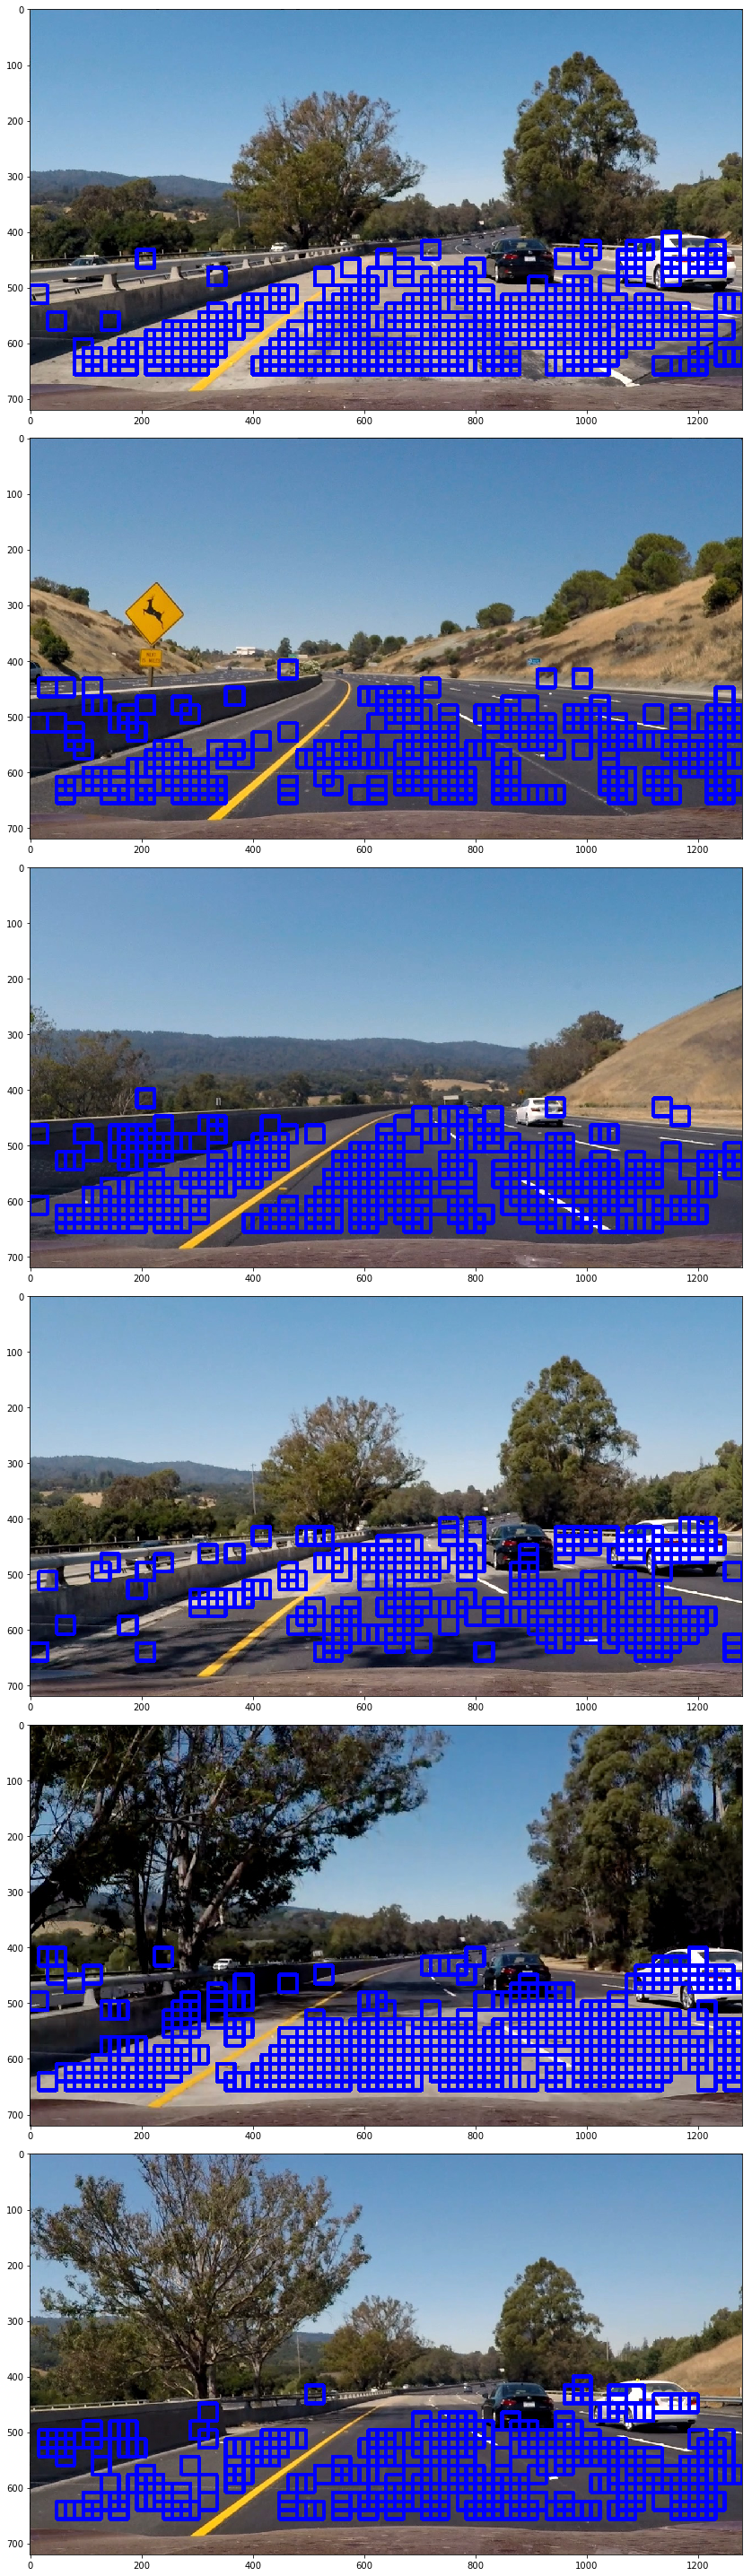

In [176]:
OutputImage = []
ystart = 400
ystop = 656
scale = 0.5

orient = 8
pix_per_cell = 16
cells_per_block = 2

debug = False

for image in TestImages:
    OutputImage.append(find_cars(image,ystart,ystop,scale,clf,Feature_scaler,orient,pix_per_cell,cells_per_block,(16,16),64,debug))

pltImages(OutputImage, "", 6, 1, 20, 40)

In [ ]:
def Lesson_Extract_FeatureAndTrainClassifier(orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    for image in 
    
    ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

In [153]:
project_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video_HOG_Sub_Sampling.mp4")
project_clip = clip1.fl_image(ProcessVideoFrame_HOG_Sub_Sampling)
%time project_clip.write_videofile(project_output, audio=False)

KeyboardInterrupt: 